In [47]:
import numpy as np

# Função de ativação ReLU
def relu(x):
    return np.maximum(0, x)

# Derivada da função de ativação ReLU
def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

# Função de ativação Softmax
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Classe MLP para classificação
class MLPClassifier:
    def __init__(self, layer_sizes, learning_rate=0.001, max_iter=1000, random_state=None):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.n_layers = len(layer_sizes)
        
    def _initialize_weights(self, n_features, n_classes):
        np.random.seed(self.random_state)
        self.weights = []
        
        # Inicialização dos pesos para as camadas ocultas e de saída
        input_dim = n_features
        for layer_size in self.layer_sizes:
            output_dim = layer_size
            weight = np.random.randn(input_dim, output_dim)
            self.weights.append(weight)
            input_dim = output_dim
        
        weight = np.random.randn(input_dim, n_classes)
        self.weights.append(weight)
    
    def _forward_pass(self, X):
        self.activations = []
        self.outputs = []
        
        # Forward pass para as camadas ocultas
        activation = X
        for weight in self.weights[:-1]:
            output = np.dot(activation, weight)
            self.activations.append(output)
            activation = relu(output)
            self.outputs.append(activation)
        
        # Forward pass para a camada de saída
        output = np.dot(activation, self.weights[-1])
        self.activations.append(output)
        self.outputs.append(softmax(output))
    
    def _backward_pass(self, X, y):
        n_samples = X.shape[0]
        n_classes = self.weights[-1].shape[1]
        
        # Backpropagation na camada de saída
        error = self.outputs[-1] - y
        
        grad = error / n_samples
        
        dW = np.dot(self.outputs[-2].T, grad)
        self.weights[-1] -= self.learning_rate * dW
        
        # Backpropagation nas camadas ocultas
        for i in range(self.n_layers - 2, -1, -1):
            error = np.dot(grad, self.weights[i + 1].T)
            grad = error * relu_derivative(self.activations[i])
            
            if i > 0:
                dW = np.dot(self.outputs[i - 1].T, grad)
            else:
                dW = np.dot(X.T, grad)
            
            self.weights[i] -= self.learning_rate * dW
    
    def fit(self, X, y):
        n_features = X.shape[1]
        n_classes = y.shape[1]
        
        self._initialize_weights(n_features, n_classes)
        
        for _ in range(self.max_iter):
            self._forward_pass(X)
            self._backward_pass(X, y)
    
    def predict(self, X):
        self._forward_pass(X)
        return self.outputs[-1]


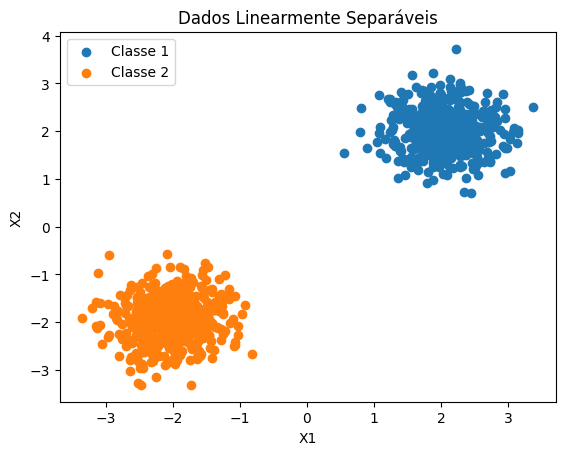

In [48]:
import numpy as np
import matplotlib.pyplot as plt
def generate_linearly_separable_data(num_samples):
    # Definindo os parâmetros para as duas classes
    class1_center = np.array([2, 2])
    class1_cov = np.array([[0.2, 0], [0, 0.2]])
    class2_center = np.array([-2, -2])
    class2_cov = np.array([[0.2, 0], [0, 0.2]])

    # Gerando dados para a classe 1
    class1_samples = np.random.multivariate_normal(class1_center, class1_cov, num_samples // 2)
    class1_labels = np.tile([1, 0], (num_samples // 2, 1))  # [1, 0] indica a classe 1

    # Gerando dados para a classe 2
    class2_samples = np.random.multivariate_normal(class2_center, class2_cov, num_samples // 2)
    class2_labels = np.tile([0, 1], (num_samples // 2, 1))  # [0, 1] indica a classe 2

    # Combinando os dados e rótulos
    x = np.concatenate((class1_samples, class2_samples), axis=0)
    y = np.concatenate((class1_labels, class2_labels), axis=0)

    # Embaralhando os dados
    indices = np.random.permutation(num_samples)
    x = x[indices]
    y = y[indices]

    return x, y

# Exemplo de uso:
num_samples = 1000  # Número total de amostras
x, y = generate_linearly_separable_data(num_samples)

# Separando as amostras por classe
class1_samples = x[y[:, 0] == 1]
class2_samples = x[y[:, 1] == 1]

# Plot dos dados
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], label='Classe 1')
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], label='Classe 2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Dados Linearmente Separáveis')
plt.legend()
plt.show()


In [61]:
# split X, y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [62]:
mlp = MLPClassifier(layer_sizes=[10, 10,2], learning_rate=0.01, max_iter=50, random_state=42)

In [63]:
def accuracy_eval(y_true, y_pred):
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    return np.mean(y_true == y_pred)

def cross_validation(model, X, y, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)
    scores = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_eval(y_test, y_pred))
    return scores

In [64]:
scores = cross_validation(mlp, X_train, y_train, k=5)
print(scores)
errors = mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_eval(y_test, y_pred)
print(accuracy)


[1.0, 0.9875, 1.0, 1.0, 0.9875]
1.0


In [65]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_y, test_y = np.eye(10)[train_y], np.eye(10)[test_y]
# reshape dataset to have a single channel
train_X, test_X = train_X.reshape((train_X.shape[0], 28 * 28)), test_X.reshape((test_X.shape[0], 28 * 28))

In [73]:
mlp = MLPClassifier(layer_sizes=[50,50,20, 10], learning_rate=0.01, max_iter=10, random_state=42)
mlp.fit(train_X, train_y)

In [74]:
y_pred = mlp.predict(test_X)
accuracy = accuracy_eval(test_y, y_pred)

In [75]:
accuracy

0.098